In [1]:
import torch
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [6]:
# Train data transformation

train_transforms = transforms.Compose([transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                       ])
                                       

# Test transform

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                      ])

Dataset and creating Train/Test split

In [7]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST(root='../data', train=False, download=True, transform=test_transforms)

Dataloader arguments and train test dataloaders

In [8]:
torch.manual_seed(100)

In [9]:
cuda = torch.cuda.is_available()

if cuda:
  print('\n CUDA is available')
  torch.cuda.manual_seed(100)
else:
  print("\n No GPU")

  


 CUDA is available


In [12]:
WORKERS = 2
BATCH_SIZE = 64

In [13]:
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=True) if cuda\
 else dict(shuffle=True, batch_size=BATCH_SIZE)

In [14]:
# train dataloader 

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)


# test dataloader

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [16]:

# def train(model, device, train_loader, optimizer, epochs=1, scheduler=None, test=False, test_loader=None, reset=None):
#     if test and not test_loader:
#         raise ValueError("`test`= True but `test_loader` not provided")
#     if reset:
#       for i in reset:
#           if i:
#               i = []
          
#     model.train()
#     for epoch in range(epochs):
#       correct = 0
#       processed = 0
#       train_loss = 0
#       print(f"\n\nepoch: {epoch+1}")
#       pbar = tqdm(train_loader)
#       for batch_idx, (data, target) in enumerate(pbar):
#           data, target = data.to(device), target.to(device)
#           optimizer.zero_grad()
#           output = model(data)
#           loss = f.nll_loss(output, target)
#           train_loss += loss.item()
#           loss.backward()
#           optimizer.step()
#           pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#           correct += pred.eq(target.view_as(pred)).sum().item()
#           processed += len(data)
#       acc = 100 * correct/processed
#       train_losses.append(train_loss)
#       train_accuracy.append(acc)
#       pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
#       if scheduler:
#           print(f'lr: {scheduler.get_last_lr()[0]}')
#           scheduler.step()
      
#       train_loss /= len(train_loader.dataset)
#       print('\nTrain set:                              Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset), 100.0 * correct / len(train_loader.dataset)))

#       if test:
#           model.eval()
#           test_loss = 0
#           correct = 0
#           with torch.no_grad():
#               for data, target in test_loader:
#                   data, target = data.to(device), target.to(device)
#                   output = model(data)
#                   test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#                   pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#                   correct += pred.eq(target.view_as(pred)).sum().item()

#           test_loss /= len(test_loader.dataset)
#           test_losses.append(test_loss)
#           test_accuracy.append(100. * correct / len(test_loader.dataset))

#           print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
#               test_loss, correct, len(test_loader.dataset),
#               100. * correct / len(test_loader.dataset)))

In [19]:

def train(model, device, train_loader, optimizer, epochs=1, scheduler=None, test=False, test_loader=None, reset=None):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")
    if reset:
      for i in reset:
          if i:
              i = []
          
    model.train()
    for epoch in range(epochs):
      correct = 0
      processed = 0
      train_loss = 0
      print(f"\n\nepoch: {epoch+1}")
      pbar = tqdm(train_loader)
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = f.nll_loss(output, target)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)

          if scheduler and  type(scheduler) == optim.lr_scheduler.CosineAnnealingLR:
              # print(f'\n>>>lr: {scheduler.get_last_lr()[0]}')
              scheduler.step()


      acc = 100 * correct/processed
      train_losses.append(train_loss)
      train_accuracy.append(acc)
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      if scheduler and not (type(scheduler) == optim.lr_scheduler.CosineAnnealingLR):
          print(f'\n>>>lr: {scheduler.get_last_lr()[0]}')
          scheduler.step()
      
      if scheduler and type(scheduler) == optim.lr_scheduler.CosineAnnealingLR:
          print('Reset scheduler')
          scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, int(len(train_loader.dataset)/BATCH_SIZE))

      train_loss /= len(train_loader.dataset)
      print('\nTrain set:                              Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset), 100.0 * correct / len(train_loader.dataset)))

      if test:
          model.eval()
          test_loss = 0
          correct = 0
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

## CODE 4 - > after BN + DO -> parameter decrease + Average Pooling 

#### Here I try to use Image Augmentation and learning rate scheduler to decrease learning rate with increasing epochs as in last code the network still looked promising.

#### Hopefully gradual and decreasing learning rate at each step and with use of image augmentation for variations in training dataset could help the network cross the threshold value for test dataset accuracy.



In [20]:
class Net2(nn.Module):        
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12)
        ) # output_size = 24
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock3 = nn.Sequential( # mixing channel information here to re-create information into 16 channels
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 12

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) # output_size = 10

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) 

        

        self.avg_pool = nn.AvgPool2d(kernel_size=6)

        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        self.dropout = nn.Dropout2d(0.12)
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x) # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.avg_pool(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model2 = Net2().to(device)

summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

In [22]:
optimizer = optim.SGD(model2.parameters(), lr=0.07,momentum=0.9)

scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.379)

train(model2, device, train_loader, optimizer, epochs=15, scheduler=scheduler, test=True, test_loader=test_loader, reset = [train_losses, test_losses, train_accuracy, test_accuracy])

  0%|          | 0/938 [00:00<?, ?it/s]



epoch: 1


100%|██████████| 938/938 [00:14<00:00, 66.25it/s]


>>>lr: 0.07

Train set:                              Accuracy: 52209/60000 (87.015000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9807/10000 (98.070000%)



epoch: 2


100%|██████████| 938/938 [00:13<00:00, 68.28it/s]


>>>lr: 0.07

Train set:                              Accuracy: 58651/60000 (97.751667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9868/10000 (98.680000%)



epoch: 3


100%|██████████| 938/938 [00:13<00:00, 69.38it/s]


>>>lr: 0.07

Train set:                              Accuracy: 59004/60000 (98.340000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9860/10000 (98.600000%)



epoch: 4


100%|██████████| 938/938 [00:13<00:00, 70.57it/s]


>>>lr: 0.02653

Train set:                              Accuracy: 59331/60000 (98.885000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.150000%)



epoch: 5


100%|██████████| 938/938 [00:13<00:00, 70.22it/s]


>>>lr: 0.02653

Train set:                              Accuracy: 59423/60000 (99.038333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.230000%)



epoch: 6


100%|██████████| 938/938 [00:13<00:00, 70.76it/s]


>>>lr: 0.02653

Train set:                              Accuracy: 59457/60000 (99.095000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.130000%)



epoch: 7


100%|██████████| 938/938 [00:13<00:00, 69.42it/s]


>>>lr: 0.01005487

Train set:                              Accuracy: 59550/60000 (99.250000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.340000%)



epoch: 8


100%|██████████| 938/938 [00:13<00:00, 71.90it/s]


>>>lr: 0.01005487

Train set:                              Accuracy: 59569/60000 (99.281667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.430000%)



epoch: 9


100%|██████████| 938/938 [00:13<00:00, 67.84it/s]


>>>lr: 0.01005487

Train set:                              Accuracy: 59575/60000 (99.291667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.380000%)



epoch: 10


100%|██████████| 938/938 [00:13<00:00, 68.12it/s]


>>>lr: 0.00381079573

Train set:                              Accuracy: 59628/60000 (99.380000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.390000%)



epoch: 11


100%|██████████| 938/938 [00:13<00:00, 68.16it/s]


>>>lr: 0.00381079573

Train set:                              Accuracy: 59652/60000 (99.420000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.390000%)



epoch: 12


100%|██████████| 938/938 [00:13<00:00, 68.85it/s]


>>>lr: 0.00381079573

Train set:                              Accuracy: 59653/60000 (99.421667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.430000%)



epoch: 13


100%|██████████| 938/938 [00:13<00:00, 70.81it/s]


>>>lr: 0.00144429158167

Train set:                              Accuracy: 59651/60000 (99.418333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.420000%)



epoch: 14


100%|██████████| 938/938 [00:13<00:00, 71.67it/s]


>>>lr: 0.00144429158167

Train set:                              Accuracy: 59671/60000 (99.451667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.430000%)



epoch: 15


100%|██████████| 938/938 [00:13<00:00, 70.82it/s]


>>>lr: 0.00144429158167

Train set:                              Accuracy: 59652/60000 (99.420000%)



Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.420000%)



Text(0.5, 1.0, 'Test Accuracy')

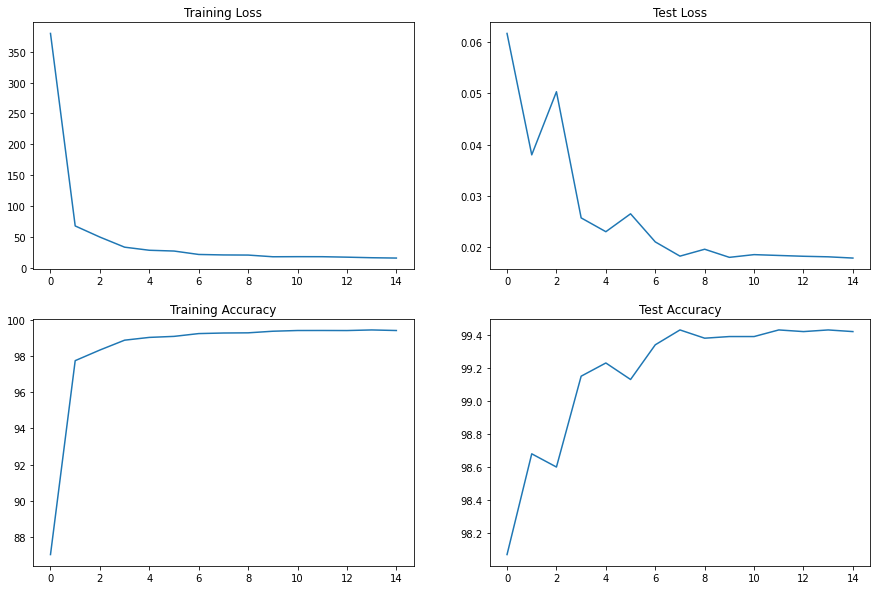

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

# Analysis

#### After adding Image Augmentation (RandomRotation from -9 to 9) and Step Learning Rate scheduler (optim.SGD(model2.parameters(), lr=0.07,momentum=0.9) & StepLR(optimizer=optimizer, step_size=3, gamma=0.379)), was able to achieve >=99.4% accuracy consistently in epochs 12, 13, 14 and 15 while training accuracy also being more than 99.4%.

#### One thing to note is that training accuracy still has scope for improvement

#### That means the model could be trained with better hyper parameters within 15 epochs

#### Total parameters used here are: 7,718

#### Try to further reduce parameters while maintaining or increasing accuracies !!
